In [1]:
@everywhere include("../Source/ChiralMC.jl")
@everywhere using ChiralMC

In [2]:
include("../Source/functions_plots_and_files.jl")

initializeTwoStatesS (generic function with 1 method)

# Dummy parallelizing
We want to utilize the built-in capabilities in Julia for using several processes for parallel computing.

The way we want to do this is by splitting the $M$ numbers of measurements we are going to take on several ($n_\text{proc}$) processes. Each process then needs its own equilibrated state to take measurements on. If we start from the same equilibrated state, this might introduce a bias, and it is thus best to equilibrate one state for each round of measurements. However to do things as simply as possible we can equilibrate two states and then take copies and run MCS on the copies until they are not correllated any more (i.e. wait a corellation time).

## Multiplying states

In [3]:
nprocs()

3

In [2]:
myid()

1

First we start with a single state and multiply this so that each process can start with a version uncorrellated to the
original

In [6]:
[1 for i=1:0]

0-element Array{Int64,1}

In [6]:
@everywhere function nMCS(ψ::State, sim::Controls, n::Int64)
    for i=1:n
        mcSweep!(ψ, sim)
    end
    return ψ
end

In [13]:
# We assume that ψ₁ and ψ₂ has already reached equilibirum
function parallelMultiplyState(ψ::State, sim::Controls, t₀::Int64)
    # Find the number of necessary equilibrium states
    np = nprocs()-1 # One of the processes is the master process.
    # Copy state to list until we have a storage for all the necessary worker states.
    ψ_list = [copy(ψ) for i=1:np+1]
    future_list = [Future() for i=1:np]
    
    # Start np workers doing t₀ number of Monte-Carlo Sweeps on ψ
    for i=1:np
        future_list[i] = @spawn nMCS(ψ, sim, t₀)
    end
    
    # Use master process to create a final state
    ψ_list[np+1] = nMCS(ψ, sim, t₀)
    
    # Now save the worker states into the list
    for i=1:np
        ψ_list[i] = fetch(future_list[i])
    end
    
    return ψ_list
end

parallelMultiplyState (generic function with 1 method)

In [14]:
# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 16     # System length
T = 0.5   # Temperature
γ = 1.0    # Order parameter amplitud

# MC parameters
M = 30    # Number of measurements
Δt = 200  # Interval between measurements (MCS)

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
# Calculate inverse temperature
β = 1/T

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

ChiralMC.Controls(1.0471975511965976, 0.4, 3.0)

Finding Equilibrium of
ChiralMC.SystConstants(16, 1.0, 11.11111111111111, 0.3, -0.125, 2.0)
ChiralMC.Controls(1.0471975511965976, 0.4, 3.0)
Searching for ΔE <= 0..
ΔE <= 0 found at t₀ = 2000!
Checking if average is close to 0..
0% of max
Equilibrium found at time 11210
over the interval [2000, 2250]
s.t. <ΔE> = -4.15 ± 0.9
std(ΔE) = 14.7


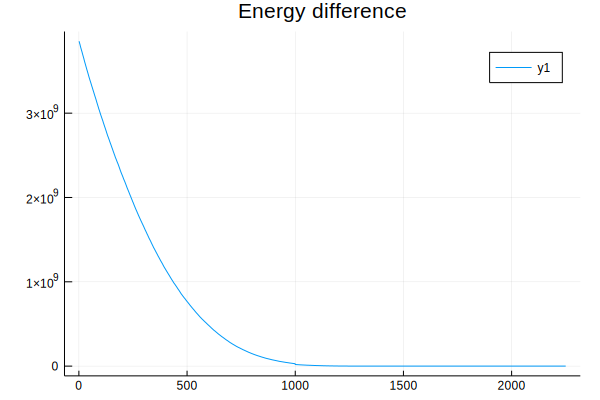

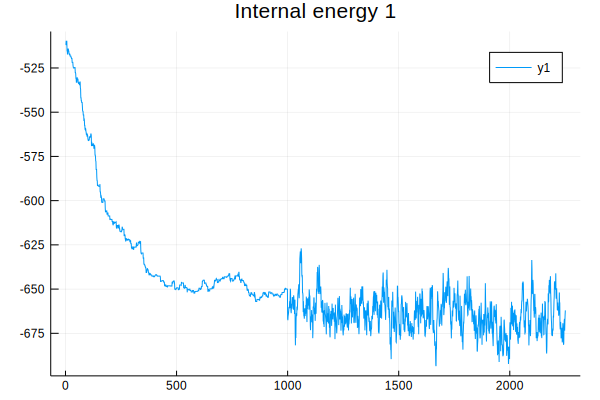

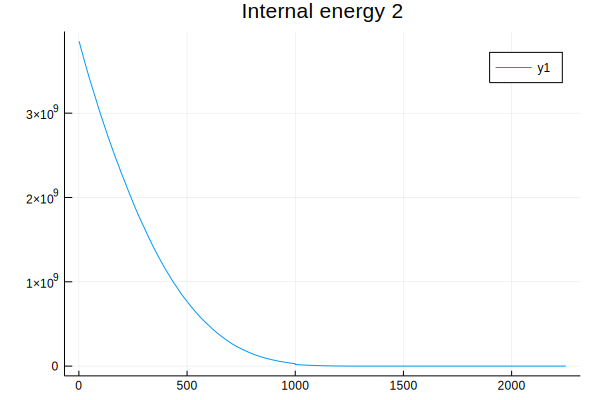

Performing extra MCS
Calculating energies and acceptance rates


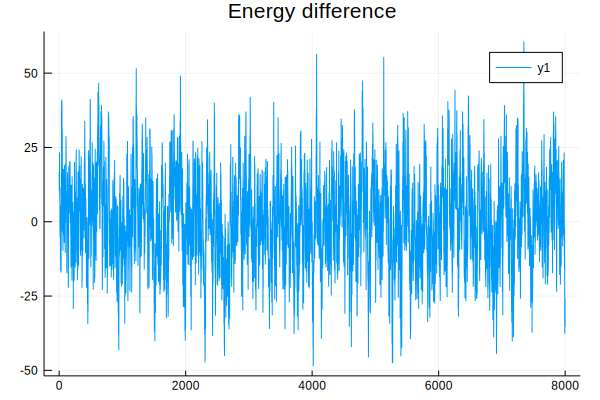

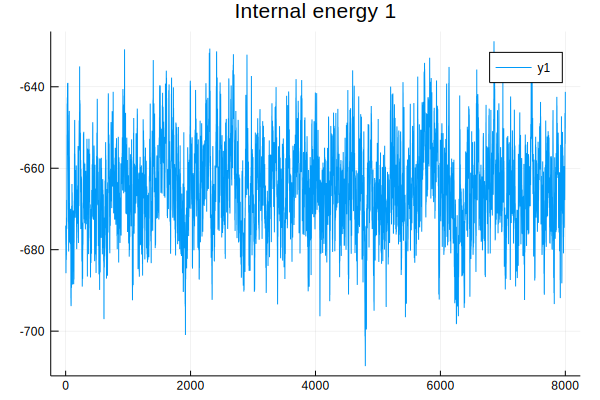

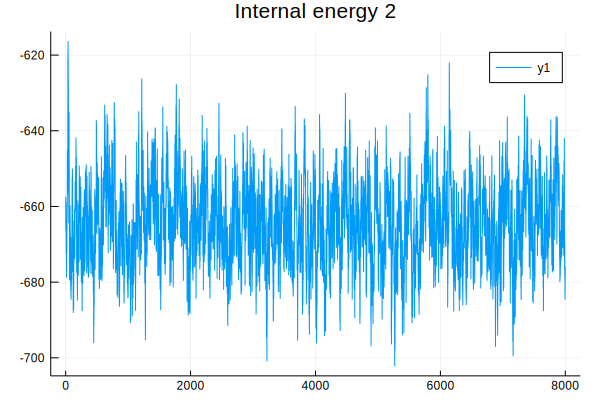

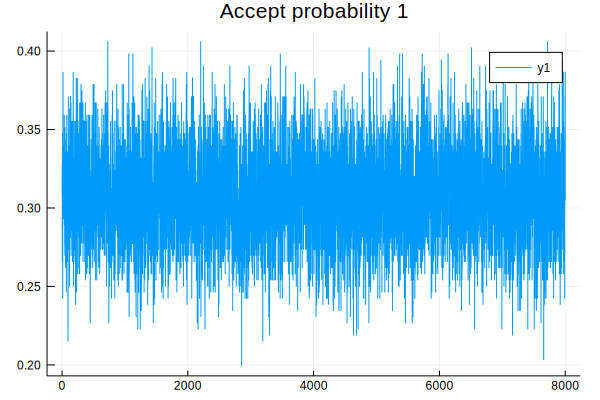

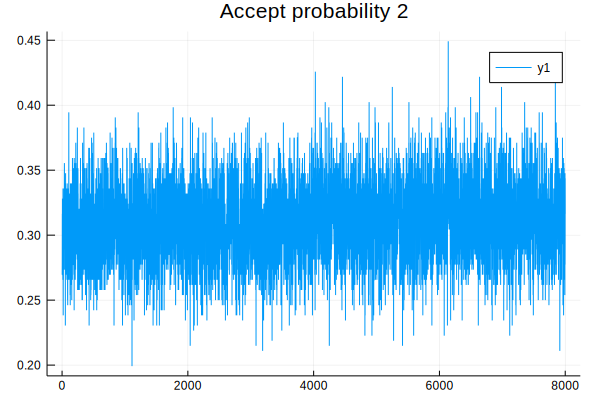

In [15]:
(ψ₁, sim₁, ψ₂, sim₂) = initializeTwoStates(syst, sim);

In [235]:
@time nMCS(ψ₁, sim₁, 11535);

 19.275854 seconds (35.58 M allocations: 1023.157 MiB, 4.45% gc time)


In [16]:
@time ψ_list = parallelMultiplyState(ψ₁, sim₁, 11448);

 11.878238 seconds (51.25 M allocations: 1.452 GiB, 5.71% gc time)


### Conclusion:
Since we have 3 processes we can create 3 uncorrelated states at the cost of 1 state. 1 state costs 4.4 seconds, if we had instead spawned 3 processes this would have created a two processes on the same worker so that it would cost ~ 8 seconds.

## Parallel measure

In [30]:
time()

1.536221040356398e9

In [40]:
floor(100/32)

3.0

In [41]:
3*32 + 4

100

In [59]:
gcd(100, 7)

1

In [7]:
using Primes

INFO: Recompiling stale cache file /home/nicolai/.julia/lib/v0.6/Primes.ji for module Primes.


In [89]:
?primes

search: primes Primes primesmask prime isprime airyprime nextprime BetaPrime



```
primes([lo,] hi)
```

Returns a collection of the prime numbers (from `lo`, if specified) up to `hi`.


In [112]:
sort([0, 1, 6, 2], rev=true)

4-element Array{Int64,1}:
 6
 2
 1
 0

In [124]:
primes(2,100)[end]

97

In [8]:
# Finds the highest divisor of M that is less than or equal to N.
# If none of the divisors of M are less than N, then 
# We assume that M,N>1
function highestDivisor(M::Int, N::Int)
    m = M
    if m <= N
        return m
    end
    # Now we know that M > N
    # First we calculate all the divisors of M except for 1 and M
    # and save them in the divisors array.
    pr = primes(2,Int(floor(sqrt(M)))+2)
    L = size(pr, 1)
    divisors = Array{Int}(0)
    for i = 1:L
        while(m%pr[i]==0)
            m /= pr[i]
            if m == 1
                break
            end
            push!(divisors, m)
            push!(divisors, M/m)
        end
    end
    
    # Then we sort this array so that high divisors come first and
    # iterate through it until a match is found.
    divisors = sort(divisors, rev=true)
    for div in divisors
        if div <= N
            return div
        end
    end
    
end

highestDivisor (generic function with 1 method)

In [9]:
# Given M measurement, divided on n processes. What is the maximum steps taken by any process
function maxSteps(M,n)
    return max(Int(floor(M/(n-1))), M%(n-1))
end
function maxSteps2(M,n)
    return Int(floor(M/n))+Int(ceil((M%n)/n))
end

maxSteps2 (generic function with 1 method)

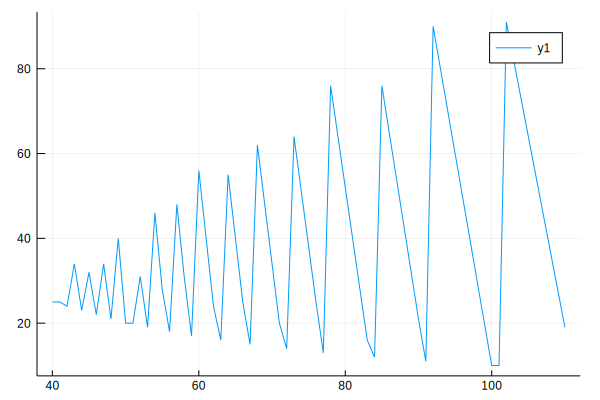

In [202]:
M = 1000
int = 40:110
plot(int, [maxSteps(M, n) for n=int])

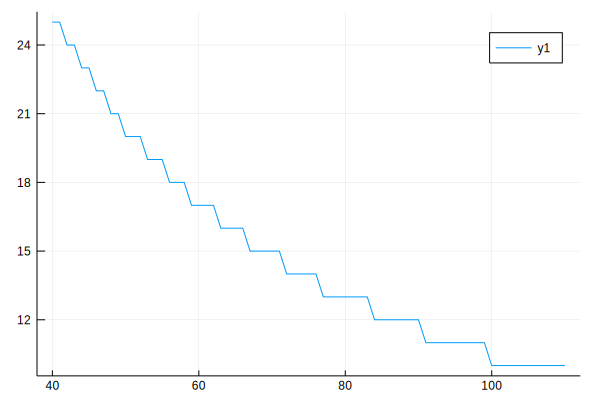

In [205]:
plot(int, [maxSteps2(M,n) for n=int])

In [137]:
M = 100
n_max = 49
n_best = 2
best = max(Int(floor(M/(n_best-1))), M%(n_best-1))
for n = 2:n_max
    prop = max(Int(floor(M/(n-1))), M%(n-1))
    if prop < best
        n_best = n
        best = prop
    end
end
println(n_best)
println(best)

34
3


In [207]:
M = 97
n = 50
println(M-Int(floor(M/n))*n == M%n)
println(div((M-M%n),n))
println(Int(floor(M/n)))

true
1
1


In [214]:
using BenchmarkTools
@benchmark fld($M,$n)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.473 ns (0.00% GC)
  median time:      11.771 ns (0.00% GC)
  mean time:        11.917 ns (0.00% GC)
  maximum time:     25.431 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

In [213]:
@benchmark Int(floor($M/$n))

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.866 ns (0.00% GC)
  median time:      7.878 ns (0.00% GC)
  mean time:        8.875 ns (0.00% GC)
  maximum time:     25.459 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     999

In [216]:
@benchmark div(($M-$M%$n),$n)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     19.064 ns (0.00% GC)
  median time:      20.509 ns (0.00% GC)
  mean time:        21.142 ns (0.00% GC)
  maximum time:     48.919 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     997

In [225]:
N = 4
(zeros(N,N)+1, zeros(N,N)+2).*5

([5.0 5.0 5.0 5.0; 5.0 5.0 5.0 5.0; 5.0 5.0 5.0 5.0; 5.0 5.0 5.0 5.0], [10.0 10.0 10.0 10.0; 10.0 10.0 10.0 10.0; 10.0 10.0 10.0 10.0; 10.0 10.0 10.0 10.0])

In [18]:
@everywhere function sfvlaMeasure{T<:Real}(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64, Δt::Int64)
    L = ψ.consts.L
    L_k = size(ks, 1)
    # Setup measurement storage
    S⁺ = [zeros(L_k,L_k) for i=1:M]
    S⁻ = [zeros(L_k,L_k) for i=1:M]
    V⁺ = [zeros(L,L) for i=1:M]
    V⁻ = [zeros(L,L) for i=1:M]
    
    # The first measurement is of the initial ψ
    (V⁺[1], V⁻[1]) = vortexSnapshot(ψ)
    
    # Then we use this to measure the structure factor
    for x=1:L_k, y=1:L_k
        (S⁺[1][y,x], S⁻[1][y,x]) = structureFunction(ks[y,x], ψ, V⁺[1], V⁻[1])
    end
    
    # For each measurement
    for m = 2:M
#        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
#        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim)
        end
        
        # Find n_z(r) of the lattice.
        (V⁺[m], V⁻[m]) = vortexSnapshot(ψ)
        
        # Find structure factor. 
        for x=1:L_k, y=1:L_k
            (S⁺[m][y,x], S⁻[m][y,x]) = structureFunction(ks[y,x], ψ, V⁺[m], V⁻[m])
        end
    end
    
    # After the loop, we should have filled up the M measurements for the matrices.
    return (S⁺, S⁻, V⁺, V⁻)
end
# Same as above, but now prints progress to STDOUT
function sfvlaMeasure{T<:Real}(ks::Array{Array{T, 1}, 2}, ψ::State, sim::Controls, M::Int64,
        Δt::Int64, option::AbstractString)
    L = ψ.consts.L
    L_k = size(ks, 1)
    s_norm_inv = 1/(L^2*ψ.consts.f)^2
    v_norm_inv = 1/two_pi
    # Setup measurement storage
    S⁺ = [zeros(L_k,L_k) for i=1:M]
    S⁻ = [zeros(L_k,L_k) for i=1:M]
    V⁺ = [zeros(L,L) for i=1:M]
    V⁻ = [zeros(L,L) for i=1:M]
    
    # The first measurement is of the initial ψ
    (V⁺[1], V⁻[1]) = v_norm_inv.*vortexSnapshot(ψ)
    
    # Then we use this to measure the structure factor
    for x=1:L_k, y=1:L_k
        (S⁺[1][y,x], S⁻[1][y,x]) = s_norm_inv.*structureFunction(ks[y,x], ψ, V⁺[1], V⁻[1])
    end
    
    # For each measurement
    for m = 2:M
        print("Measurement progress: $(Int(round(m/M*100,0)))% \r")
        flush(STDOUT)
        
        # Take Δt MCS
        for i = 1:Δt
            mcSweep!(ψ, sim)
        end
        
        # Find n_z(r) of the lattice.
        (V⁺[m], V⁻[m]) = v_norm_inv.*vortexSnapshot(ψ)
        
        # Find structure factor. 
        for x=1:L_k, y=1:L_k
            (S⁺[m][y,x], S⁻[m][y,x]) = s_norm_inv.*structureFunction(ks[y,x], ψ, V⁺[m], V⁻[m])
        end
    end
    
    # After the loop, we should have filled up the M measurements for the matrices.
    return (S⁺, S⁻, V⁺, V⁻)
end

sfvlaMeasure (generic function with 2 methods)

In [9]:

x = [0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8]
println(autocorrTime(x))
println(ess_factor_estimate(x))

LoadError: [91mUndefVarError: autocorrTime not defined[39m

In [19]:
using MCMCDiagnostics
# Given np+1 uncorrelated states in ψ_list we use these to make M measurements of the vortex lattice by splitting
# the M measurements on the np workers as well as the master process. In this version we continuously discard
# the measurements and only save the averages and second moments.
function parallelSFVLA!{T<:Real}(ks::Array{Array{T, 1}, 2}, 
        ψ_list::Array{State,1}, sim::Controls, M::Int64, Δt::Int64)
    syst = ψ_list[1].consts
    L = syst.L
    
    # Checking that the k matrix has equal dimensions
    L_k = size(ks, 1)
    size(ks, 2) == L_k || throw(DomainError())
    
    s_norm_inv = 1/(L^2*syst.f*two_pi)^2
    v_norm_inv = 1/two_pi
    
    # Splitting the problem into np sub-problems.
    np = nprocs()
    # Minimum amount of work pr. process
    M_min = Int(floor(M/np))
    # Number of workers doing +1 extra work
    nw = M%np
    
    # Make sure that we have enough states
    length(ψ_list) >= np || throw(Error("ERROR: Not enough states in list"))
    
    # Setup worker futures
    futures = [Future() for i=1:(np-1)]
    
    println("Starting $(M) measurements on $(np) processes doing max $(M_min + Int(ceil(nw/np))) measurements each
on a $(L)×$(L) system.")
    
    # Start +1 workers
    for i = 1:nw
        futures[i] = @spawn sfvlaMeasure(ks, ψ_list[i], sim, M_min+1, Δt)
    end
    # Start remaining workers
    for i = 1:np-nw-1
        futures[nw+i] = @spawn sfvlaMeasure(ks, ψ_list[nw+i], sim, M_min, Δt)
    end
    # Make the master process work as well
    (S⁺, S⁻, V⁺, V⁻) = sfvlaMeasure(ks, ψ_list[np], sim, M_min, Δt, "-v")
    
    println("Measurements done, collecting parallell results.")
    
    # Collect results
    for i = 1:np-1
        (new_S⁺, new_S⁻, new_V⁺, new_V⁻) = fetch(futures[i])
        S⁺ = vcat(S⁺, new_S⁺)
        S⁻ = vcat(S⁻, new_S⁻)
        V⁺ = vcat(V⁺, new_V⁺)
        V⁻ = vcat(V⁻, new_V⁻)
    end
    @test length(S⁺) == M
    
    println("Parallell measurements done. Processing.")
    
    # Normalizing results
    V⁺ = v_norm_inv.*V⁺
    V⁻ = v_norm_inv.*V⁻
    S⁺ = s_norm_inv.*S⁺
    S⁻ = s_norm_inv.*S⁻
    
    # Calculate averages and second moments
    av_S⁺ = mean(S⁺)
    av_S⁻ = mean(S⁻)
    av_V⁺ = mean(V⁺)
    av_V⁻ = mean(V⁻)
    sm_S⁺ = zeros(L_k, L_k)
    sm_S⁻ = zeros(L_k, L_k)
    sm_V⁺ = zeros(L,L)
    sm_V⁻ = zeros(L,L)
    for m = 1:M
        sm_S⁺ += S⁺[m].^2
        sm_S⁻ += S⁻[m].^2
        sm_V⁺ += V⁺[m].^2
        sm_V⁻ += V⁻[m].^2
    end
    sm_S⁺ = sm_S⁺./M
    sm_S⁻ = sm_S⁻./M
    sm_V⁺ = sm_V⁺./M
    sm_V⁻ = sm_V⁻./M
    
    # Error calculation of average vorticity
    τ_V⁺ = [1/ess_factor_estimate([V⁺[m][y,x] for m=1:M])[1] for y=1:L, x=1:L]
    τ_V⁻ = [1/ess_factor_estimate([V⁻[m][y,x] for m=1:M])[1] for y=1:L, x=1:L]
    
    err_V⁺ = (1+2.*τ_V⁺).*(sm_V⁺ - av_V⁺.^2)./(M-1)
    err_V⁻ = (1+2.*τ_V⁻).*(sm_V⁻ - av_V⁻.^2)./(M-1)
    
    # Error calculation of structure factor.
    τ_S⁺ = [1/ess_factor_estimate([S⁺[m][y,x] for m=1:M])[1] for y=1:L_k, x=1:L_k]
    τ_S⁻ = [1/ess_factor_estimate([S⁻[m][y,x] for m=1:M])[1] for y=1:L_k, x=1:L_k]
    
    err_S⁺ = (1+2.*τ_S⁺).*(sm_S⁺ - av_S⁺.^2)./(M-1)
    err_S⁻ = (1+2.*τ_S⁻).*(sm_S⁻ - av_S⁻.^2)./(M-1)
    
    sum_n⁺ = sum()
    
    
    # Finding max values over the matrices.
    max_S⁺= maximum(av_S⁺)
    max_S⁻ = maximum(av_S⁻)
    max_err_S⁺ = maximum(err_S⁺)
    max_err_S⁻ = maximum(err_S⁻)
    max_τ_S⁺ = maximum(τ_S⁺)
    max_τ_S⁻ = maximum(τ_S⁻)
    println("\nMax (S⁺, S⁻)\n($(max_S⁺), $(max_S⁻))")
    println("Max δ(S⁺, S⁻)\n($(max_err_S⁺), $(max_err_S⁻))")
    println("Max correlation time\n($(max_τ_S⁺), $(max_τ_S⁻))")
    
    return (av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻)
end

parallelSFVLA! (generic function with 1 method)

In [28]:
sum(V⁺[end])

2.220446049250313e-15

## Testing of this works on a real project

In [20]:
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L]
length(ψ_list)
@everywhere const two_pi = 2π

In [24]:
(av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = parallelSFVLA!(k_matrix, 
    ψ_list, sim₁, 200, 200);

Starting 200 measurements on 3 processes doing max 67 measurements each
on a 16×16 system.
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Max (S⁺, S⁻)
(0.1655581865797, 0.1799871626779342)
Max δ(S⁺, S⁻)
(0.015489156147954425, 0.020677706415854022)
Max correlation time
(37.8178678007466, 36.686927326824105)


In [29]:
(av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻) = structureFunctionVortexLatticeAvg!(k_matrix, 
    ψ_list[end], sim₁, 200, 200);

Making 200 measurements using 40000 MCS over a 16×16 matrix of ks.
Measurement progress: 100% 
Max (S⁺, S⁻)
(0.2285282061018506, 0.2467127981510086)
Max δ(S⁺, S⁻)
(0.001748134063803955, 0.0010884742507480483)
Max correlation time
(1.0, 1.0)


In [23]:
@everywhere function nᵣ(c::SystConstants, ϕ::LatticeSite, ϕᵣ₊₁::LatticeSite, ϕᵣ₊₂::LatticeSite, ϕᵣ₊₁₊₂::LatticeSite, h_pos::Int64)
    vort_θ⁺ = (mod(ϕᵣ₊₁.θ⁺ - ϕ.θ⁺, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₁.θ⁺, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos)
        - mod(ϕᵣ₊₁₊₂.θ⁺ - ϕᵣ₊₂.θ⁺, two_pi)  + ϕᵣ₊₂.A[1]
        - mod(ϕᵣ₊₂.θ⁺ - ϕ.θ⁺, two_pi)  + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
    vort_θ⁻ = (mod(ϕᵣ₊₁.θ⁻ - ϕ.θ⁻, two_pi) - ϕ.A[1] + mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₁.θ⁻, two_pi) - (ϕᵣ₊₁.A[2] + two_pi*c.f*h_pos)
        - mod(ϕᵣ₊₁₊₂.θ⁻ - ϕᵣ₊₂.θ⁻, two_pi)  + ϕᵣ₊₂.A[1]
        - mod(ϕᵣ₊₂.θ⁻ - ϕ.θ⁻, two_pi)  + (ϕ.A[2] + two_pi*c.f*(h_pos-1)))
    return vort_θ⁺, vort_θ⁻
end

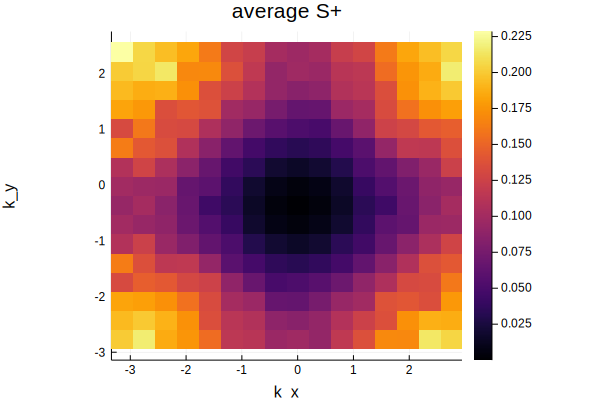

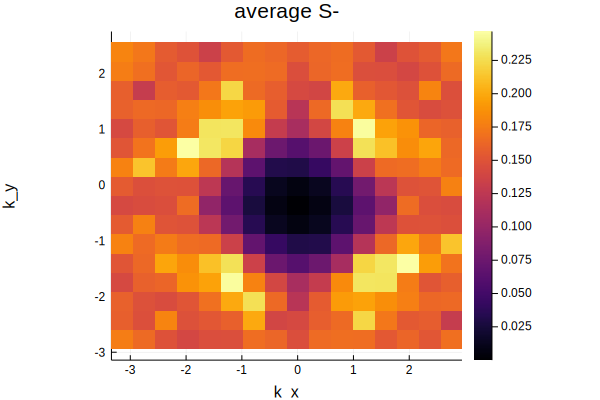

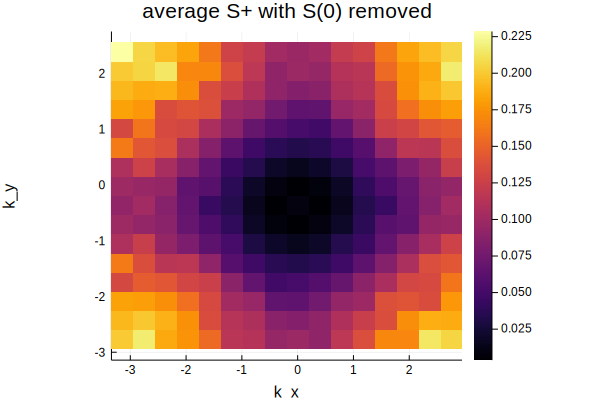

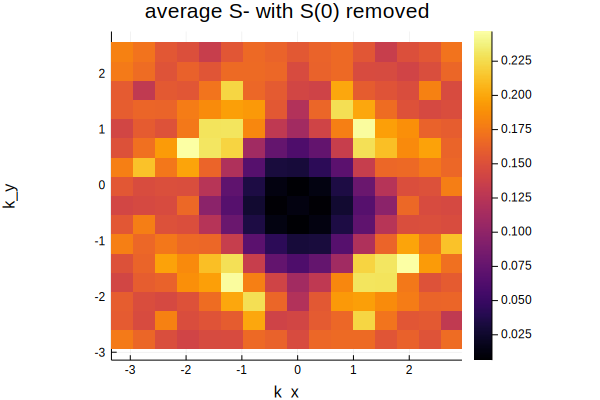

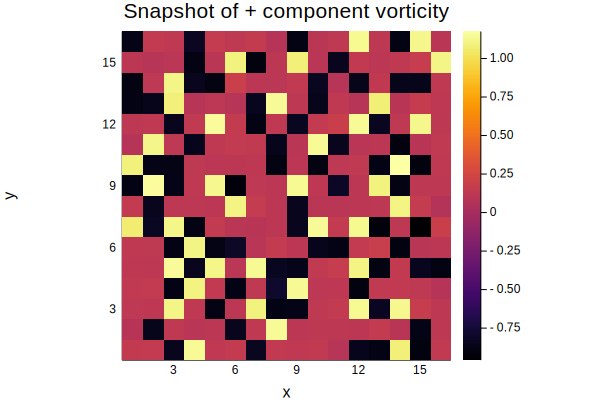

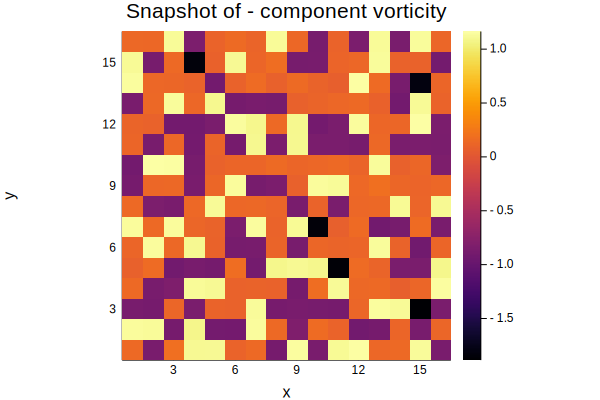

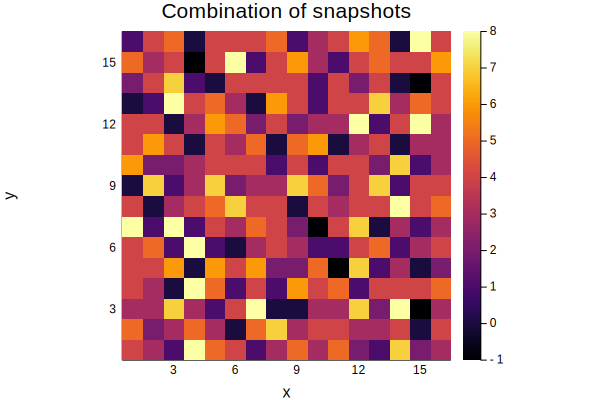

S⁺(0) ≈ 4.302184301186099e-33
S⁻(0) ≈ 4.852935507201e-33
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	9
% of vortex kind (-1, 0): 	12
% of vortex kind (-1, 1): 	7
% of vortex kind (0, -1): 	17
% of vortex kind (0, 0): 	29
% of vortex kind (0, 1): 	10
% of vortex kind (1, -1): 	5
% of vortex kind (1, 0): 	5
% of vortex kind (1, 1): 	5

Sum of + component vorticity in the snapshot: -1.6930901125533637e-15
Sum of - component vorticity in the snapshot: 4.163336342344337e-16


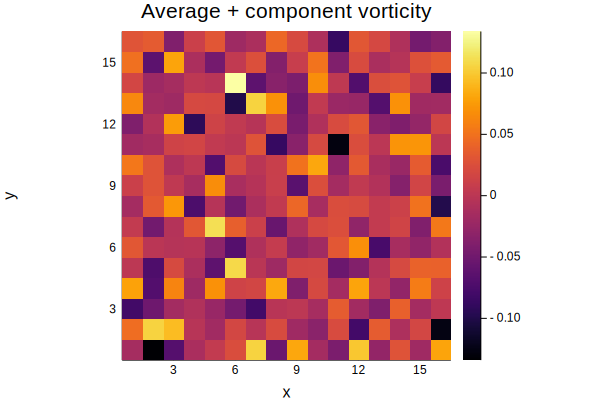

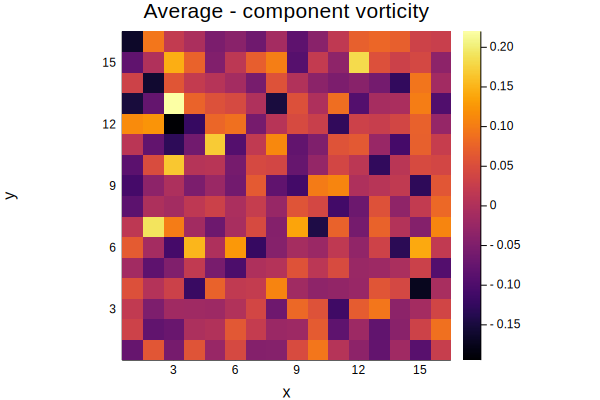

In [30]:
plotStructureFunctionVortexLattice(av_V⁺, av_V⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], av_S⁺, av_S⁻, k_matrix)